In [1]:
#@title **Instalar Paquetes**

!pip install open3d
!pip install plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.0
    Unin

In [2]:
#@title **Cargar librerias**
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import requests
from PIL import Image
from io import BytesIO
import plotly.graph_objects as go
import open3d as o3d
from PIL import Image
import random
import ipywidgets as widgets
from IPython.display import display
import matplotlib.gridspec as gridspec
from pathlib import Path
from imageio.v3 import imread

In [3]:
def show_images(img1, img2, title1, title2):

    print("Image sizes:", img1.shape, "and", img2.shape)
    plt.figure(figsize=(15,9))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap="gray")
    plt.title(title1)

    plt.subplot(1, 2, 2)
    plt.imshow(img2,cmap="gray")
    plt.title(title2)
    plt.show()

def draw_epilines_and_points(img1, lines, pts1):
    img_with_epilines = img1.copy()
    color = (255, 0, 0)

    for line, pt1 in zip(lines, pts1):
        x0, y0 = map(int, [0, -line[2] / line[1]])
        x1, y1 = map(int, [img1.shape[1], -(line[2] + line[0] * img1.shape[1]) / line[1]])
        img_with_epilines = cv.line(img_with_epilines, (x0, y0), (x1, y1), color, 1)
        pt1 = (int(pt1[0]), int(pt1[1]))
        img_with_epilines = cv.circle(img_with_epilines, pt1, 5, color, -1)
    return img_with_epilines


def add_epilines_to_rectified_images(imgLeft, imgRight, ptsLeft, ptsRight, h1, h2):
    ptsLeftRtf = cv.perspectiveTransform(np.float32(ptsLeft).reshape(-1, 1, 2), h1).reshape(-1, 2)
    ptsRightRtf = cv.perspectiveTransform(np.float32(ptsRight).reshape(-1, 1, 2), h2).reshape(-1, 2)

    linesLeftRtf = np.zeros((len(ptsLeftRtf), 3))
    linesRightRtf = np.zeros((len(ptsRightRtf), 3))
    linesLeftRtf[:, 1] = -1
    linesRightRtf[:, 1] = -1
    linesLeftRtf[:, 2] = ptsLeftRtf[:, 1]
    linesRightRtf[:, 2] = ptsRightRtf[:, 1]
    imgLeftWithEpilines = draw_epilines_and_points(imgLeft, linesLeftRtf, ptsLeftRtf)
    imgRightWithEpilines = draw_epilines_and_points(imgRight, linesRightRtf, ptsRightRtf)

    return imgLeftWithEpilines, imgRightWithEpilines

def drawlines(img1, img2, lines, pts1, pts2):
    imgLines = img1.copy()
    imgLines1 = img2.copy()
    r, c = imgLines.shape[:2]
    color = (255, 255, 255)


    for line, pt1, pt2 in zip(lines, pts1, pts2):
        x0, y0 = map(int, [0, -line[2] / line[1]])
        x1, y1 = map(int, [c, -(line[2] + line[0] * c) / line[1]])
        imgLines = cv.line(imgLines, (x0, y0), (x1, y1), color, 1)

        pt1 = (int(pt1[0]), int(pt1[1]))
        pt2 = (int(pt2[0]), int(pt2[1]))
        imgLines = cv.circle(imgLines, pt1, 5, color, -1)
        imgLines1 = cv.circle(imgLines1, pt2, 5, color, -1)

    return imgLines



def plot_disparitymap(imgL,imgR,disparity_map):
    disparity_map[(disparity_map <= 0)] = 1

    plt.figure(figsize=(16,5))
    plt.subplot(1,3,1)
    plt.imshow(imgL, cmap='gray')
    plt.title("Image Left")

    plt.subplot(1,3,2)
    plt.imshow(imgR, cmap='gray')
    plt.title("Image Right")

    plt.subplot(1,3,3)
    plt.imshow(disparity_map, cmap='viridis')
    plt.colorbar()
    plt.title('Disparity map')


def plot_3d(image, depth):
  H, W = depth.shape
  xx, yy = np.meshgrid(np.arange(W), np.arange(H))
  points_grid = np.stack(((xx-117.6728)/50, (yy-101.1728)/399.7684, np.ones_like(xx)), axis=0) * depth

  mask = np.ones((H, W), dtype=bool)

  # Remove flying points
  mask[1:][np.abs(depth[1:] - depth[:-1]) > 1] = False
  mask[:,1:][np.abs(depth[:,1:] - depth[:,:-1]) > 1] = False

  points = points_grid.transpose(1,2,0)[mask]
  colors = image[mask].astype(np.float64) / 255

  NUM_POINTS_TO_DRAW = 100000

  subset = np.random.choice(points.shape[0], size=(NUM_POINTS_TO_DRAW,), replace=False)
  points_subset = points[subset]
  colors_subset = colors[subset]

  print("""
  Controls:
  ---------
  Zoom:      Scroll Wheel
  Translate: Right-Click + Drag
  Rotate:    Left-Click + Drag
  """)

  x, y, z = points_subset.T

  fig = go.Figure(
      data=[
          go.Scatter3d(
              x=x, y=-z, z=-y, # flipped to make visualization nicer
              mode='markers',
              marker=dict(size=1, color=colors_subset)
          )
      ],
      layout=dict(
          scene=dict(
              xaxis=dict(visible=True),
              yaxis=dict(visible=True),
              zaxis=dict(visible=True),
          )
      )
  )
  fig.show()



def show_disparity_maps(disp_bm, disp_sgbm):

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(disp_bm, cmap="viridis")
    plt.title("StereoBM")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(disp_sgbm, cmap="viridis")
    plt.title("StereoSGBM")
    plt.colorbar()
    plt.show()

def compare_stereo_algorithms(numDisparities, blockSize):

    """
    Compara StereoBM y StereoSGBM con parámetros ajustables.

    Parameters:
        numDisparities (int): Rango de búsqueda de disparidad (múltiplo de 16).
        blockSize (int): Tamaño del bloque de comparación (impar ≥ 5).
    """
    imgL, imgR = descargar_imagenes(nombre_dataset)


    if numDisparities % 8 != 0:
        numDisparities += 8 - (numDisparities % 8)
    if blockSize % 2 == 0:
        blockSize += 1
    blockSize = max(5, blockSize)

    # StereoBM
    stereo_bm = cv.StereoBM_create(numDisparities=numDisparities, blockSize=blockSize)
    disp_bm = stereo_bm.compute(imgL, imgR).astype(np.float32) / 16.0

    # StereoSGBM
    stereo_sgbm = cv.StereoSGBM_create(numDisparities=numDisparities,blockSize=blockSize)
    disp_sgbm = stereo_sgbm.compute(imgL, imgR).astype(np.float32) / 16.0
    show_disparity_maps(disp_bm, disp_sgbm)

num_disp_slider = widgets.IntSlider(value=16, min=16, max=256, step=16, description='NumDisparities')
block_size_slider = widgets.IntSlider(value=3, min=3, max=21, step=2, description='BlockSize')


def stereo_sgdm(nombre_dataset):
  imgL, imgR = descargar_imagenes(nombre_dataset)
  stereo_sgbm = cv.StereoSGBM_create(numDisparities=16,blockSize=13)
  disp_sgbm = stereo_sgbm.compute(imgL, imgR).astype(np.float32) / 16.0

  return disp_sgbm



def visualizar_mapa_profundidad(depth_map, umbral=2.0, cmap='viridis'):
    """
    Visualiza el mapa de profundidad y el histograma con un espacio visible en el medio.
    """

    depth = np.copy(depth_map)
    depth[depth <= 0] = np.nan
    depth[depth > umbral] = np.nan
    valid_depth = depth[~np.isnan(depth)]


    fig = plt.figure(figsize=(14, 4))
    spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[1, 0.01, 1])


    ax1 = fig.add_subplot(spec[0])
    im = ax1.imshow(depth, cmap="jet_r")
    ax1.set_title("Mapa de profundidad")
    ax1.axis('off')
    cbar = fig.colorbar(im, ax=ax1, shrink=0.8)
    cbar.set_label("Profundidad (m)")


    ax_blank = fig.add_subplot(spec[1])
    ax_blank.axis('off')


    ax2 = fig.add_subplot(spec[2])
    ax2.hist(valid_depth.ravel(), bins=50, color='teal')
    ax2.set_title("Histograma de profundidad")
    ax2.set_xlabel("Profundidad (m)")
    ax2.set_ylabel("Frecuencia")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def visualizar_mapa_profundidad_2(depth_map, umbral=2.0, cmap='jet_r', guardar=False, nombre_archivo="mapa_sin_bordes.png"):
    """
    Visualiza el mapa de profundidad y el histograma con un espacio visible en el medio.
    Si `guardar=True`, guarda solo el mapa de profundidad sin ejes, colorbar ni bordes.
    """
    depth = np.copy(depth_map)
    depth[depth <= 0] = np.nan
    depth[depth > umbral] = np.nan
    valid_depth = depth[~np.isnan(depth)]

    if guardar:
        # Solo imagen sin colorbar ni histograma
        fig, ax = plt.subplots()
        ax.imshow(depth, cmap=cmap)
        ax.axis('off')
        plt.savefig(nombre_archivo, bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close()
    else:
        # Visualización con todo
        fig = plt.figure(figsize=(14, 4))
        spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[1, 0.01, 1])

        ax1 = fig.add_subplot(spec[0])
        im = ax1.imshow(depth, cmap=cmap)
        ax1.set_title("Mapa de profundidad")
        ax1.axis('off')
        cbar = fig.colorbar(im, ax=ax1, shrink=0.8)
        cbar.set_label("Profundidad (m)")

        ax_blank = fig.add_subplot(spec[1])
        ax_blank.axis('off')

        ax2 = fig.add_subplot(spec[2])
        ax2.hist(valid_depth.ravel(), bins=50, color='teal')
        ax2.set_title("Histograma de profundidad")
        ax2.set_xlabel("Profundidad (m)")
        ax2.set_ylabel("Frecuencia")
        ax2.grid(True)

        plt.tight_layout()
        plt.show()


In [ ]:
#@title Librerias necesarias
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_theme()

In [ ]:
#@title Visualizar los mapas de profundidad
#@markdown Este metodo se saco del codigo de github del dataset
import numpy as np
import matplotlib
import matplotlib.cm as cm
import cv2

def visualize_depth_as_numpy(depth, cmap="jet", is_sparse=True):
    """
    Args:
        data (HxW): depth data
        cmap: color map (inferno, plasma, jet, turbo, magma, rainbow)
    Returns:
        vis_data (HxWx3): depth visualization (RGB)
    """

    # x = depth.cpu().numpy()
    x = np.nan_to_num(depth)  # change nan to 0

    inv_depth = 1 / (x + 1e-6)

    if is_sparse:
        vmax = 1 / np.percentile(x[x != 0], 5)
    else:
        vmax = np.percentile(inv_depth, 95)

    normalizer = matplotlib.colors.Normalize(vmin=inv_depth.min(), vmax=vmax)
    mapper = cm.ScalarMappable(norm=normalizer, cmap=cmap)
    vis_data = (mapper.to_rgba(inv_depth)[:, :, :3] * 255).astype(np.uint8)
    if is_sparse:
        vis_data[inv_depth > vmax] = 0
    return vis_data

In [6]:
#@title Montar el drive
from google.colab import drive
drive.mount("/content/gdrive")
%cd "/content/gdrive/MyDrive/Procesamiento de imagenes/Proyecto Final/Depth-Estimation-with-StereoThermal-Images/FIReStereo_sample_dataset/stereo_thermal_depth/frick_1"

Mounted at /content/gdrive
/content/gdrive/MyDrive/Procesamiento de imagenes/Proyecto Final/Depth-Estimation-with-StereoThermal-Images/FIReStereo_sample_dataset/stereo_thermal_depth/frick_1


# 1. Exploración de los datos

In [8]:
#@title Carga de imagenes termicas
## Nombre de los documentos
images_name = np.asarray(['00906.png', '01220.png', '01504.png', '01605.png', '01810.png'])

## Listas para guardar las imagenes
image_left = []
image_right = []

## Leer imagenes
for i in images_name:
  image_left.append(cv.imread(f"img_left/{i}", cv.IMREAD_UNCHANGED))
  image_right.append(cv.imread(f"img_right/{i}", cv.IMREAD_UNCHANGED))

## Graficar/mostrar las imagenes
for i, (j, k) in enumerate(zip(image_left, image_right)):
  plt.figure(figsize=[15,18])
  plt.subplot(121)
  plt.imshow(j)
  plt.title(f"{i+1}.Imagen de la izquierda")
  plt.axis('off')
  plt.subplot(122)
  plt.imshow(k)
  plt.title(f"{i+1}.Imagen de la derecha")
  plt.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [9]:
#@title Caracteristicas de las imagenes

print('--'*30)

print("Imagen izquierda")
print('Profundidad de Bits: ', image_left[0].dtype)
print("Valor maximo = ", image_left[0].max(), "Valor minimo = ", image_left[0].min())
print('Tamaño: ', image_left[0].shape)

print("Imagen derecha")
print('Profundidad de Bits: ', image_right[0].dtype)
print("Valor maximo = ", image_right[0].max(), "Valor minimo = ", image_right[0].min())
print('Tamaño: ', image_left[0].shape)

print('--'*30)

------------------------------------------------------------
Imagen izquierda
Profundidad de Bits:  uint16
Valor maximo =  22255 Valor minimo =  21765
Tamaño:  (512, 640)
Imagen derecha
Profundidad de Bits:  uint16
Valor maximo =  21783 Valor minimo =  21276
Tamaño:  (512, 640)
------------------------------------------------------------


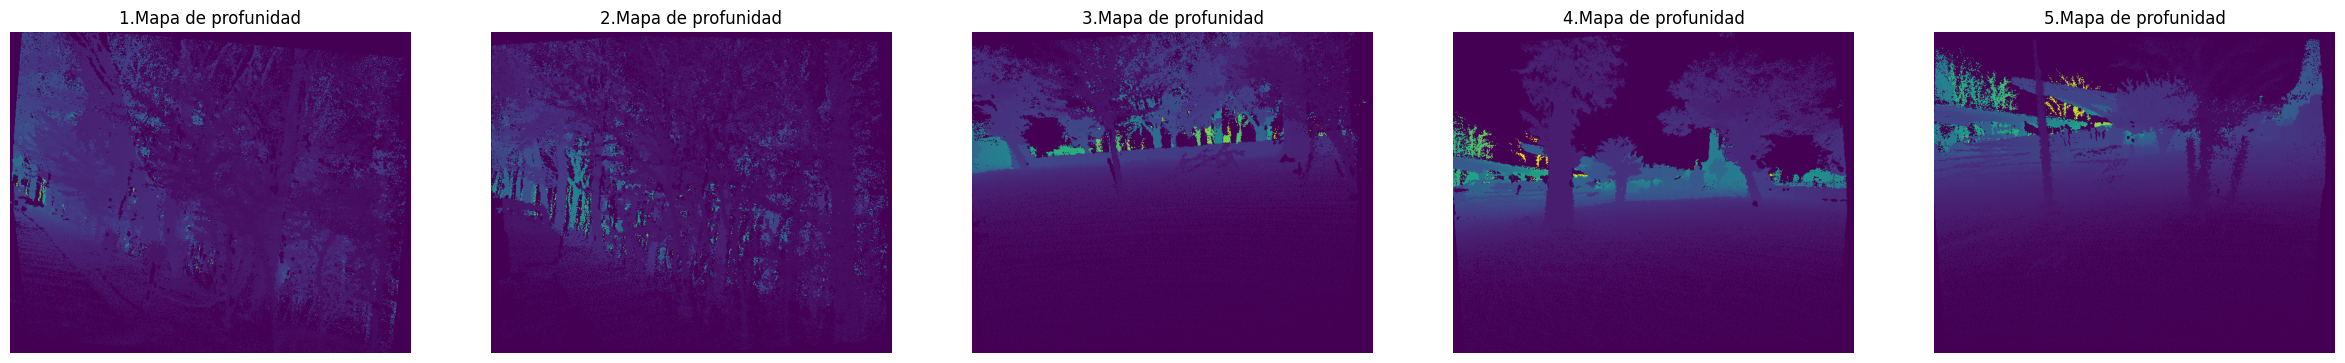

In [10]:
#@title Carga de los mapas de profundidad
## Listas para guardar los mapas
depth = []

## Leer mapas de profundidad
for i in images_name:
  depth.append(cv.imread(f"depth_filtered/{i}", cv.IMREAD_UNCHANGED))

## Graficar/mostrar los mapas
plt.figure(figsize=(30,100))
for i, j in enumerate(depth):
  plt.subplot(1,5,i+1)
  plt.imshow(j)
  plt.title(f"{i+1}.Mapa de profunidad")
  plt.axis('off')

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
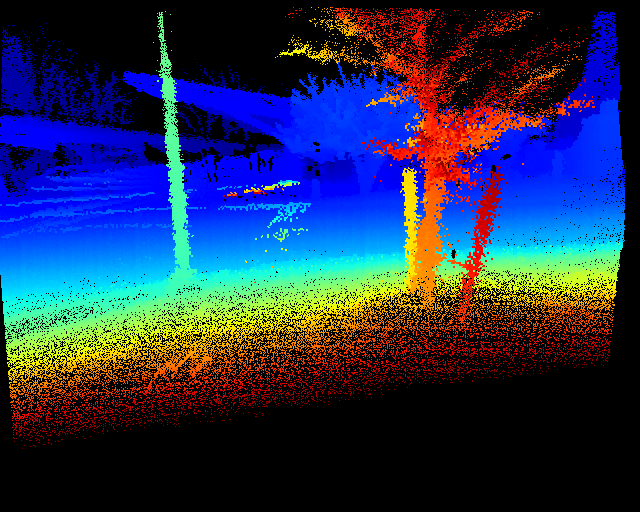

In [ ]:
#@title Visualizar los mapas
visualize_depth_as_numpy(depth[4])

In [11]:
#@title Caracteristicas de los mapas de pronfidad
print('--'*30)

print("Mapa de profundida")
print('Profundidad de Bits: ', depth[0].dtype)
print("Valor maximo = ", depth[0].max(), "Valor minimo = ", depth[0].min())
print('Tamaño: ', depth[0].shape)

print('--'*30)

------------------------------------------------------------
Mapa de profundida
Profundidad de Bits:  uint16
Valor maximo =  23971 Valor minimo =  0
Tamaño:  (512, 640)
------------------------------------------------------------


# 2. Preparación de las imagenes

In [20]:
## Normalizar los datos
image_left_norm = [((i -i.min()) / (i.max() - i.min()))*255 for i in image_left]
image_right_norm = [((i -i.min()) / (i.max() - i.min()))*255 for i in image_right]

for i, (imgL, imgR) in enumerate(zip(image_left_norm, image_right_norm)):
  print('--'*30)
  print('Valores normalizados:')
  print(f'Par de imagenes {i+1}: left(min: {imgL.min()}, max: {imgL.max()}), right(min: {imgL.min()}, max: {imgL.max()})')

## Parametros de calibracion intrinsecos y extrinsecos


------------------------------------------------------------
Valores normalizados:
Par de imagenes 1: left(min: 0.0, max: 255.0), right(min: 0.0, max: 255.0)
------------------------------------------------------------
Valores normalizados:
Par de imagenes 2: left(min: 0.0, max: 255.0), right(min: 0.0, max: 255.0)
------------------------------------------------------------
Valores normalizados:
Par de imagenes 3: left(min: 0.0, max: 255.0), right(min: 0.0, max: 255.0)
------------------------------------------------------------
Valores normalizados:
Par de imagenes 4: left(min: 0.0, max: 255.0), right(min: 0.0, max: 255.0)
------------------------------------------------------------
Valores normalizados:
Par de imagenes 5: left(min: 0.0, max: 255.0), right(min: 0.0, max: 255.0)


In [21]:
#@title Keypoints { display-mode: "form" }

sift = cv.xfeatures2d.SIFT_create()
keyPointsLeft, descriptorsLeft = sift.detectAndCompute(image_left_norm[0].astype(np.uint8), None)
keyPointsRight, descriptorsRight = sift.detectAndCompute(image_right_norm[0].astype(np.uint8), None)

FLANN_INDEX_KDTREE = 0
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
searchParams = dict(checks=50)
flann = cv.FlannBasedMatcher(indexParams, searchParams)

goodMatches = []
ptsLeft = []
ptsRight = []
matches = flann.knnMatch(descriptorsLeft, descriptorsRight, k=2)

print(f"Número de coincidencias antes del test de ratio: {len(matches)}")

for m, n in matches:
    if m.distance < 0.8 * n.distance:
        goodMatches.append(m)
        ptsLeft.append(keyPointsLeft[m.queryIdx].pt)
        ptsRight.append(keyPointsRight[m.trainIdx].pt)

print(f"Número de buenas coincidencias después del test de ratio: {len(goodMatches)}")


Número de coincidencias antes del test de ratio: 533
Número de buenas coincidencias después del test de ratio: 87


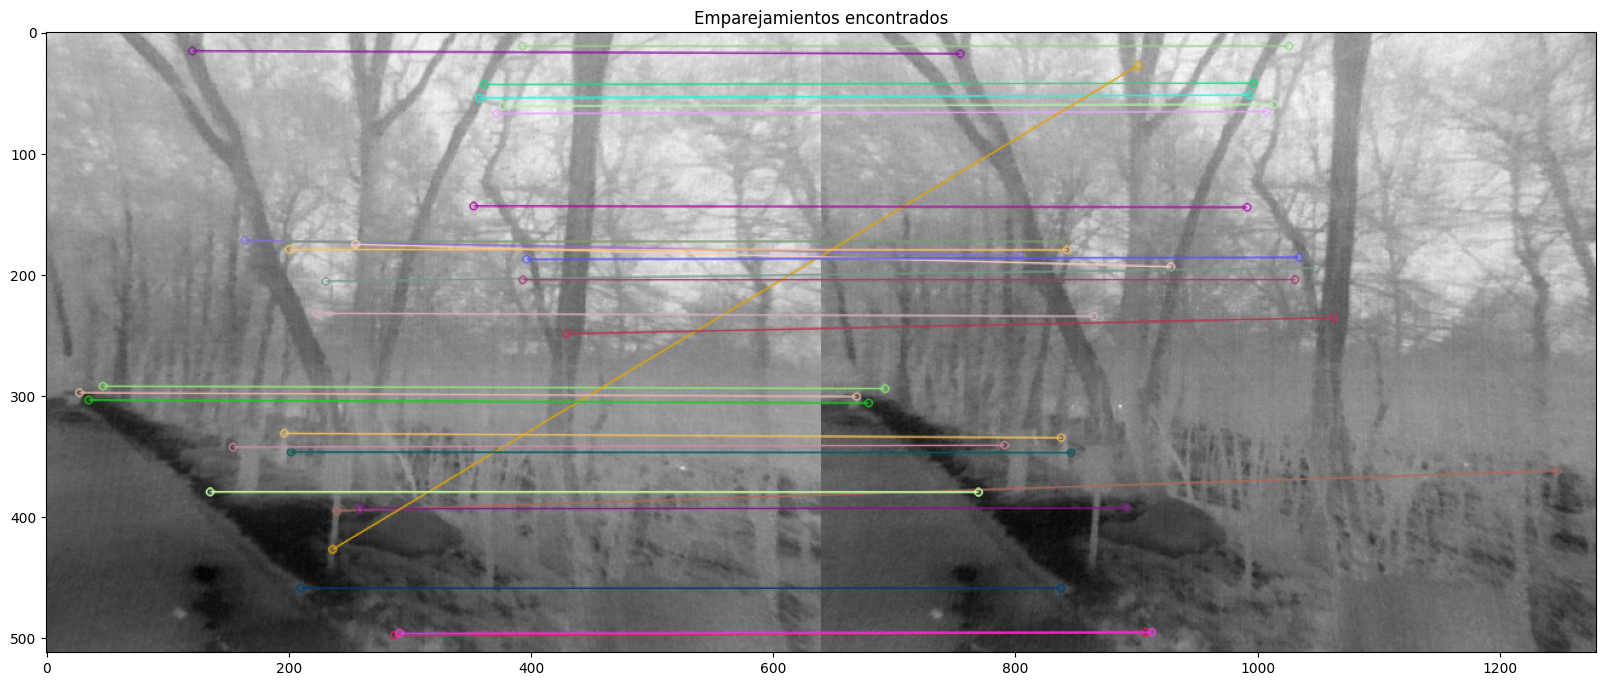

In [22]:
#@title Veamos algunos emparejamientos de nuestro algoritmo { display-mode: "form" }

parejas = random.sample(goodMatches,min(30, len(goodMatches)))
imgMatches = cv.drawMatches(image_left_norm[0].astype(np.uint8), keyPointsLeft, image_right_norm[0].astype(np.uint8), keyPointsRight, parejas , None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,10))
plt.imshow(imgMatches)
plt.title("Emparejamientos encontrados")
plt.show()

In [23]:
#@title Obtenemos la matriz fundamental { display-mode: "form" }
ptsLeft = np.float32(ptsLeft)
ptsRight = np.float32(ptsRight)
F, mask = cv.findFundamentalMat(ptsLeft, ptsRight, cv.FM_LMEDS)

ptsLeft = ptsLeft[mask.ravel() == 1]
ptsRight = ptsRight[mask.ravel() == 1]
print(F)

[[-4.33366903e-06  2.07017694e-04 -6.69646325e-02]
 [-2.01117027e-04  8.56322520e-06 -4.67854960e-02]
 [ 6.49665114e-02  4.14909698e-02  1.00000000e+00]]


Image sizes: (512, 640) and (512, 640)


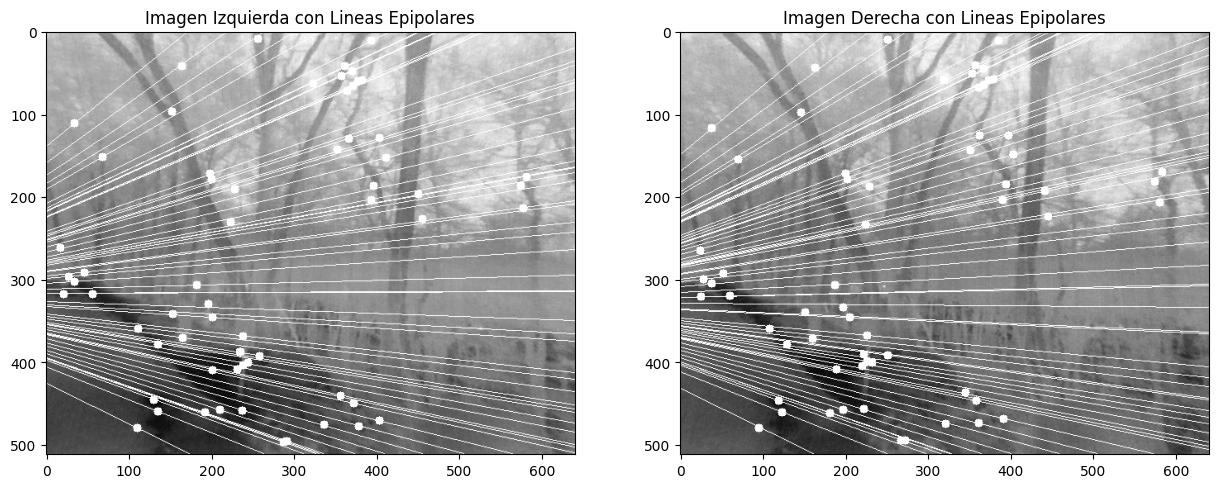

In [25]:
#@title Veamos algunas lineas epipolares { display-mode: "form" }
linesLeft = cv.computeCorrespondEpilines(ptsRight.reshape(-1, 1, 2), 2, F)
linesLeft = linesLeft.reshape(-1, 3)
img5 = drawlines(image_left_norm[0].astype(np.uint8), image_right_norm[0].astype(np.uint8), linesLeft, ptsLeft, ptsRight)

linesRight = cv.computeCorrespondEpilines(ptsLeft.reshape(-1, 1, 2), 1, F)
linesRight = linesRight.reshape(-1, 3)
img3 = drawlines(image_right_norm[0].astype(np.uint8), image_left_norm[0].astype(np.uint8), linesRight, ptsRight, ptsLeft)

show_images(img5,img3, "Imagen Izquierda con Lineas Epipolares", "Imagen Derecha con Lineas Epipolares")



Image sizes: (512, 640) and (512, 640)


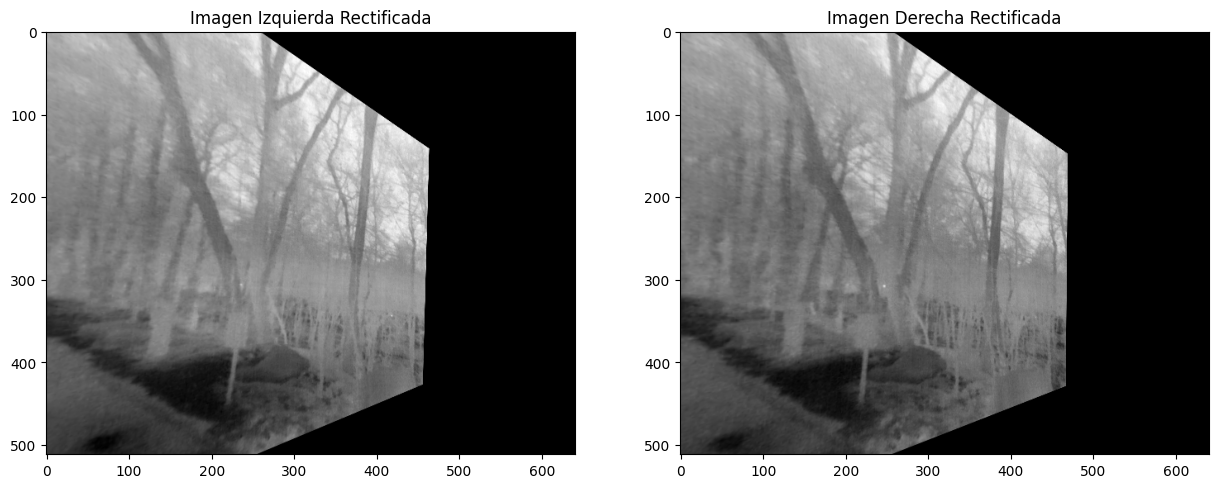

In [26]:
#@title Asi son las homografías { display-mode: "form" }
_, h1, h2 = cv.stereoRectifyUncalibrated(np.float32(ptsLeft), np.float32(ptsRight), F, image_left_norm[0].astype(np.uint8).shape[:2])

# Aplicar las homografías para rectificar las imágenes
imgLeftRectified = cv.warpPerspective(image_left_norm[0].astype(np.uint8), h1, (image_left_norm[0].astype(np.uint8).shape[1], image_left_norm[0].astype(np.uint8).shape[0]))
imgRightRectified = cv.warpPerspective(image_right_norm[0].astype(np.uint8), h2, (image_right_norm[0].astype(np.uint8).shape[1], image_right_norm[0].astype(np.uint8).shape[0]))
show_images(imgLeftRectified,imgRightRectified, "Imagen Izquierda Rectificada", "Imagen Derecha Rectificada")


Image sizes: (512, 640) and (512, 640)


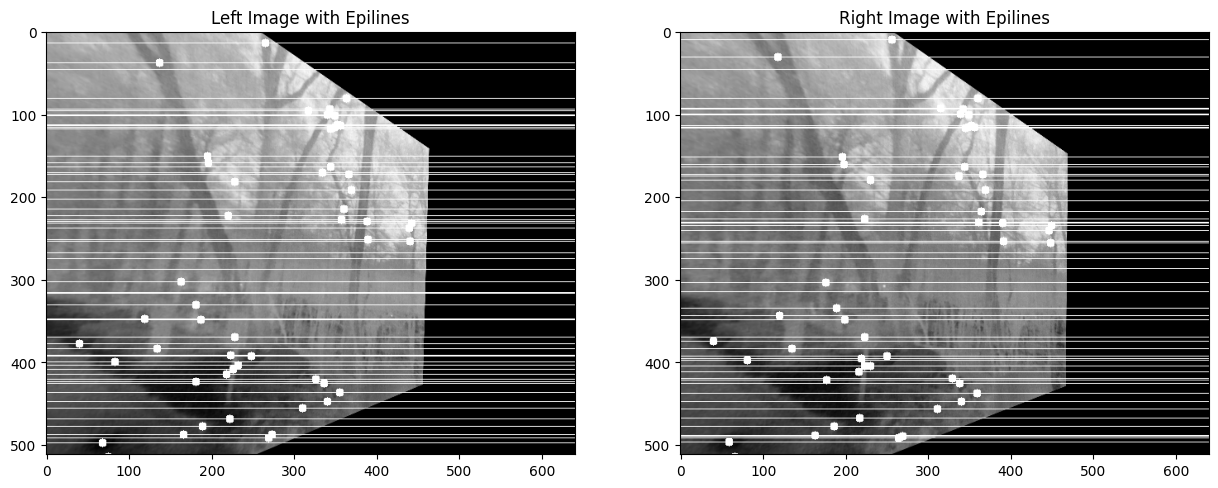

In [27]:
#@title Asi se ven las imagenes rectificadas con sus lineas epipolares { display-mode: "form" }
imgLeftWithEpilines, imgRightWithEpilines = add_epilines_to_rectified_images(imgLeftRectified, imgRightRectified, ptsLeft, ptsRight, h1, h2)
show_images(imgLeftWithEpilines, imgRightWithEpilines, "Left Image with Epilines", "Right Image with Epilines")


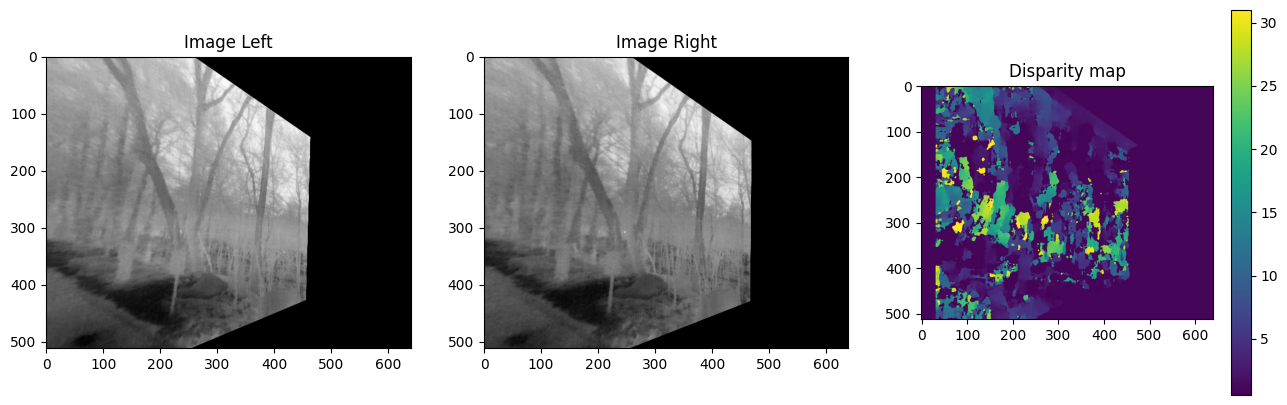

In [28]:
#@title Mapa de disparidad { display-mode: "form" }
stereo_nonrecti = cv.StereoSGBM_create(numDisparities=32,blockSize=21)
disp_nonrecti = stereo_nonrecti.compute(imgLeftRectified, imgRightRectified).astype(np.float32) / 16.0
plot_disparitymap(imgLeftRectified, imgRightRectified, disp_nonrecti)